In [193]:
# importamos las librerías que vamos a necesitar
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

plt.rcParams['figure.figsize'] = (12.0, 8.0)
sns.set_style('white')

In [167]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
# Cargamos los datos con los que vamos a realizar el estudio

clients = pd.read_csv('/content/drive/MyDrive/mwc22-client_table.csv', sep=',', decimal=',') # dataset con información de los clientes de Nuwefruit
orders = pd.read_csv('/content/drive/MyDrive/mwc22-orders_table.csv', sep=',') # dataset con información de los pedidos realizados por los clientes
test = pd.read_csv('/content/drive/MyDrive/mwc22-client_table+-+test_x.csv', sep=',', decimal=',') # dataset sobre el que realizar la predicción del target (client_segment)


#### EDA

Se realiza un análisis exploratorio con el fin de estudiar:

- Las ventas y la actividad de los clientes
- Evaluar el impacto de la promoción

Empezamos analizando el conjunto de datos de los pedidos realizados, 'orders'.

In [169]:
# inspección visual de la estructura del dataset
orders.head()

,CLIENT ID,NB PRODS,ORDER ID,FRUIT_PRODUCT
0,18070505,5,671907264,Apple
1,18070505,10,671907264,Orange
2,18070505,5,671907264,Kiwi
3,18070505,10,671907264,Pear
4,18070505,5,671907264,Cheery


In [170]:
# información más detallada del contenido del dataset y del tipo de variables que éste contiene
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66912 entries, 0 to 66911
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CLIENT ID      66912 non-null  int64 
 1   NB PRODS       66912 non-null  int64 
 2   ORDER ID       66912 non-null  int64 
 3   FRUIT_PRODUCT  66912 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.0+ MB


In [171]:
# Inspección de si tenemos valores NaN o null
orders.isnull().values.any()

False

In [172]:
# Alguna información estadística acerca del dataset
orders.describe()

,CLIENT ID,NB PRODS,ORDER ID
count,6.691200e+04,66912.000000,6.691200e+04
mean,2.613407e+07,4.528112,6.722533e+08
std,8.473596e+06,5.788227,3.205826e+06
min,1.807050e+07,-80.000000,6.638335e+08
25%,2.017427e+07,1.000000,6.694803e+08
50%,2.438055e+07,3.000000,6.719971e+08
75%,2.538708e+07,5.000000,6.750893e+08
max,4.836586e+07,198.000000,6.832132e+08


Si bien el ID único del cliente y del pedido no son relevantes, se observa la variable 'NB PRODS' correspondiente al número de productos de la variedad de fruta en el pedido, donde una unidad de producto equivale a diez piezas de fruta.

En este caso, se observa que el mínimo corresponde a un valor negativo de -80, que no tiene ningún sentido al estar hablando de número de productos (es decir, NB_PRODS debe de ser un número entero positivo siempre).

A continuación se puede ver en el boxplot la presencia de este conjunto de valores negativos:

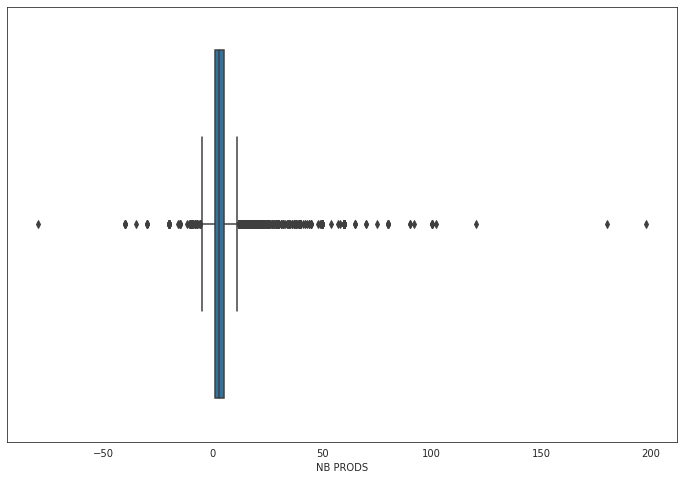

In [173]:
sns.boxplot(data=orders, x = 'NB PRODS')

Una opción sería considerar al conjunto de valores negativos error humano a la hora de introducir el dato, y en ese sentido se podría tomar el valor absoluto de éstos con el fin de tener un estudio estadístico correcto.

En este caso se desconoce el origen de los datos por lo que se opta a considerarlos un error y por lo tanto eliminarlos del conjunto de datos.

Algo similar ocurre con los valores otuliers, falta un conocimiento del dominio para determinar si realmente son otuliers que se deben eliminar o si por el contrario tienen sentido dentro del conjunto de datos y por ello se deben de mantener. 

Por ejemplo, el máximo de 198 pedidos (equilavente a 1980 piezas de fruta) no parece tener demasiado sentido para un cliente particular, pero sí para un mayorista o un gran restaurante. En este caso, se deciden mantener estos valores y únicamente se eliminan aquellos negativos.

representación de los valores negativos: 0.54 % del dataset original


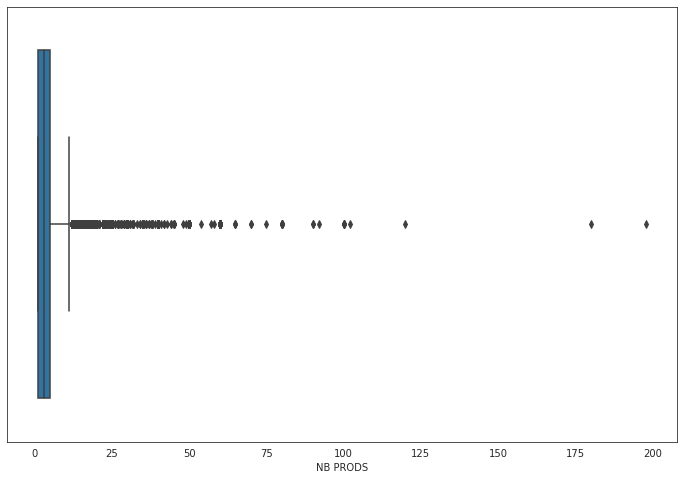

In [174]:
# generamos nuevo dataset con únicamente valores positivos para la variable NN PRODS
orders_filtered = orders[(orders['NB PRODS']>0)]

sns.boxplot(data=orders_filtered, x = 'NB PRODS')

# vemos cuánto representa haber eliminado el conjunto de valores negativos
print('representación de los valores negativos:',round((len(orders)-len(orders_filtered))*100/len(orders),2),'% del dataset original')

Vamos a analizar cuáles son las variedades de fruta más vendidas.

In [175]:
# orders_filtered['FRUIT_PRODUCT'].value_counts().index -> para ordenar de mayor a menor por frecuencia de aparición

orders_filtered=orders_filtered.copy() #hacemos copy del dataset

# ordenamos el dataset utilizando las 'frutas' como índice, siendo el orden ascendente según la frecuencia de aparición de la fruta en el dataset
orders_filtered['FRUIT_PRODUCT']= pd.Categorical(orders_filtered['FRUIT_PRODUCT'],categories=['Kiwi', 'Orange', 'Lemon', 'Cheery', 'Nuwe Fruit', 'Pear', 'Nectarine',
       'Apple', 'Banana', 'Grape', 'Coconut', 'Apricot', 'Devil Fruit',
       'Papaya', 'Mango', 'Plum', 'Blueberry', 'Lime', 'Strawberry',
       'Pomegranate', 'Watermelon', 'Melon', 'Pineapple', 'Jackfruit'], ordered= True )

# esta ejecución no es especialmente relevante, pero hará que el plot que se muestre ordene el histograma de mayor a menor, facilitando su interpretación

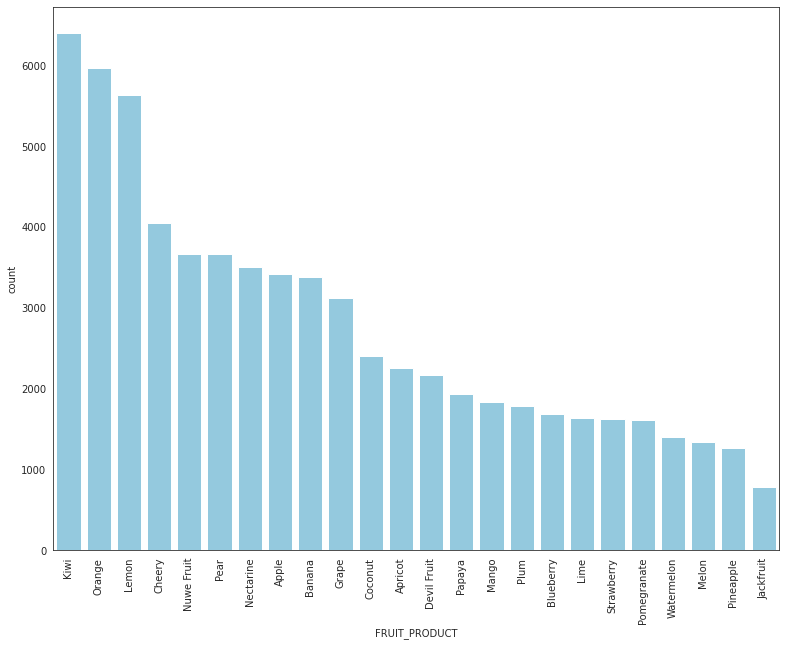

In [176]:
plt.figure(figsize=(13,10))
sns.countplot(data=orders_filtered, x ='FRUIT_PRODUCT', color='skyblue') 
plt.xticks(rotation=90)
plt.show()

Observamos que la mayor parte de los pedidos son los relacionados con las frutas como el Kiwi, seguido de las Naranjas, el Limón y la cereza.
Al mismo tiempo, los pedidos relacionados con el Melón, la Piña o el Jackfruit, representan el menor número de pedidos.

Cada una de las variedades de fruta requeriría un análisis más detallado acerca de posibles presencias de otuliers.

A continuación se analiza la relación de cada una de las variedades de fruta (sin representación visual de outlrs) con respecto a la variable 'NB PRODS':

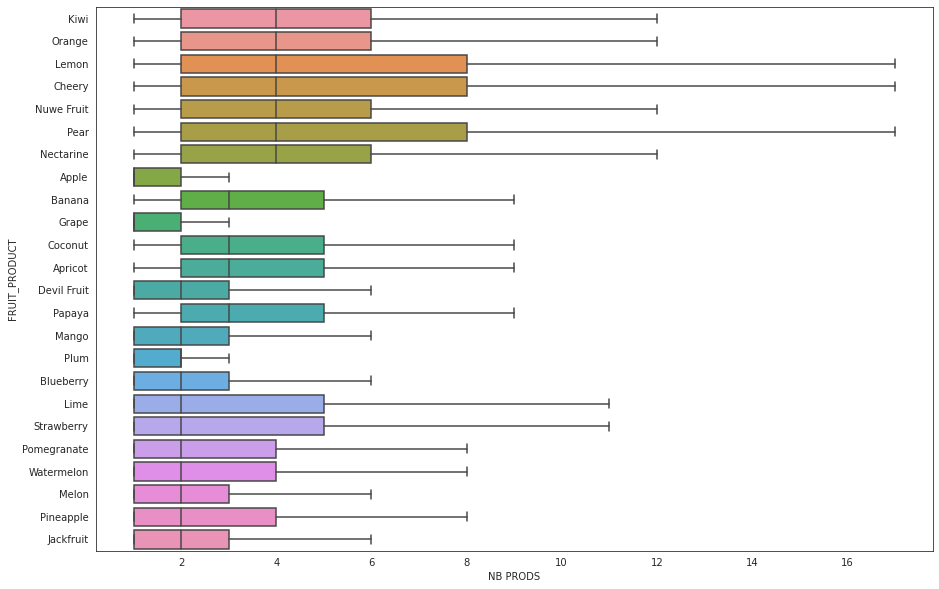

In [177]:
plt.figure(figsize=(15,10))
sns.boxplot(data=orders_filtered,y='FRUIT_PRODUCT', x = 'NB PRODS', showfliers=False)

Se comprueba que las frutas con las medias en la variable 'NB PRODS' más elevadas se corresponden a las frutas con más representación, como el Kiwi, la Naranja, el Limón, la Cereza, la NuweFruit, la Pera y la Nectarina. Esto tiene sentido, ya que se espera que haya una relación directa entre la cantidad de pedidos de una determinada variedad de fruta y el número de piezas de fruta de ésta en cada pedido.

Aunque existen algunas excepciones, por ejemplo, si se observa la Manzana (que ocupa el 8acto lugar en mayor representación de pedidos) tiene un valor medio menor (1.95) que al de otras frutas con menor representación, lo que significa que esta pieza de fruta aparece en muchos pedidos, pero se compran menos unidades en términos de piezas de producto (= NB PRODS).

En contraste con la manzana, por ejemplo, la Papaya teniendo una frecuencia de aparición considerablemente menor que la Manzana, tiene una media en NB PRODS de 4.3, lo que significa que, siendo una fruta que aparece en menor cantidad de pedidos que la manzana, cuando se compra, se compra una mayor cantidad de piezas del producto.

Se podría ir realizando un análisis semejante para cada una de las variedades de fruta.

Con todo esto, ha quedado claro la relación entre las ventas y los distintos tipos de frutas así como la relativa correlación existente entre la frequencia de pedidos de una variedad de fruta y el número de piezas de fruta en cada pedido.

A continuación se pasa a analizar el dataset con información relativa a los clientes, con éste seremos capaces de estudiar el posible impacto de la promoción sobre las ventas.



In [178]:
# comenzamos igual que antes con una inspección visual del dataset
clients.head()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,24321771,6,67.25,201.75,0
1,24321859,2,58.33,350.00,0
2,24321880,3,46.67,112.00,0
3,24321957,2,50.00,600.00,0
4,24321962,4,10.00,120.00,0


In [179]:
# información más detallada del contenido del dataset y del tipo de variables que éste contiene
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35884 entries, 0 to 35883
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CLIENT ID               35884 non-null  int64  
 1   CLIENT_SEGMENT          35884 non-null  int64  
 2   AVG CONSO               35884 non-null  float64
 3   AVG BASKET SIZE         35884 non-null  float64
 4   RECEIVED_COMMUNICATION  35884 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 1.4 MB


In [180]:
# Inspección de si tenemos NaN o similar
clients.isnull().values.any()

False

In [181]:
# Alguna información estadística acerca del dataset
clients.describe()

,CLIENT ID,CLIENT_SEGMENT,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
count,3.588400e+04,35884.000000,35884.000000,35884.000000,35884.000000
mean,2.706058e+07,3.123593,64.534437,181.218610,0.507998
std,8.835076e+06,1.512932,64.381932,129.604691,0.499943
min,1.807311e+07,1.000000,0.830000,10.000000,0.000000
25%,2.053311e+07,2.000000,20.830000,100.000000,0.000000
50%,2.462190e+07,3.000000,50.000000,160.000000,1.000000
75%,3.298538e+07,4.000000,88.170000,225.000000,1.000000
max,4.836594e+07,6.000000,2433.330000,3400.200000,1.000000


Volvemos a notar posible presencia de outliers para las variables consumo medio (AVG CONSO) y tamaño medio de la cesta (AVG BASKET SIZE).

Por ejemplo, para la variable 'AVG CONSO' se observa que su valor medio se situa en 64.5, esto es, un consumo medio de 64 piezas de fruta al mes, que equivaldría a un consumo medio de 2 piezas de fruta al día, algo asequible y razonable para un ser humano.

Sin embargo, esta misma variable tiene valores mucho más elevados, hasta un máximo de 2433 piezas de fruta mensuales, que equivaldría a un consumo medio de más de 40 piezas de fruta al día, lo cual no parece nada realista para un ser humano.

Nuevamente sería necesario un mayor conocimiento del dominio para considerar si estos valores son en efecto otuliers o si bien pertenecen a valores asociados a grandes organismos como mayoristas y restaurantes que también son clientes habituales de la empresa.

En el siguiente boxplot se pueden ver claramente esa cantidad de valores 'atípicos' que se alejan estadísticamente del resto de datos.

En efecto, se puede observar que a partir del 'AVG CONSO'= 225 (correspondiente al cuartil Q3) se tiene todo un rango de valores comprendido entre [230,2433] que son valores que podrían corresponder a grandes comercios con un consumo medio mensual mucho más elevado que el resto de clientes particulares.

Algo muy semejante ocurriría con la variable 'AVG BASKET SIZE', la cual tiene también un amplio rango de valores estadísticamente atípico que nuevamente requiriría un mayor conocimiento del dominio para su correcto tratamiento.

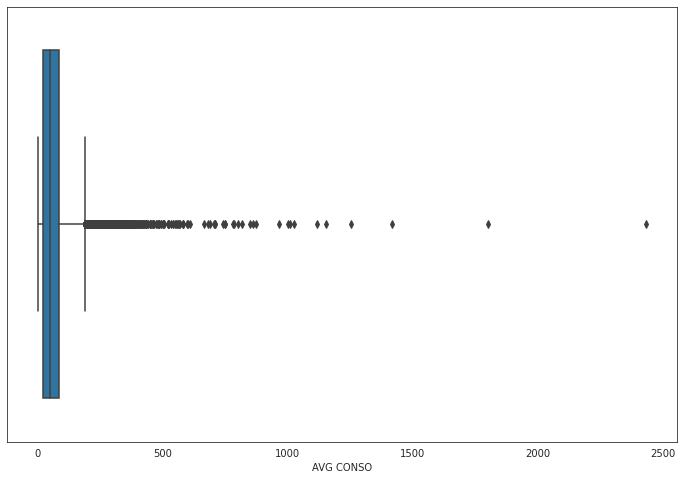

In [182]:
sns.boxplot(data = clients, x = 'AVG CONSO') # boxplot para la variable 'AVG CONSO'



En este caso, se ha optado por finalmente mantener todo el conjunto de datos. Se puede probar que, eliminando el conjunto de valores atípicos potencialmente outliers los modelos predictivos empeoran, especialmente a la hora de predecir correctamente los clientes del segmento 6.

Así pues, por ese motivo y por la falta de conocimiento del dominio se decide mantener íntegramente el conjunto total de datos.

Con el fin de estudiar si hay un impacto real de las promociones ('received_communication) o no, se procede a realizar un boxplot comparativo para cada uno de las segmentación de los clientes, tal y como se muestra a continuación.

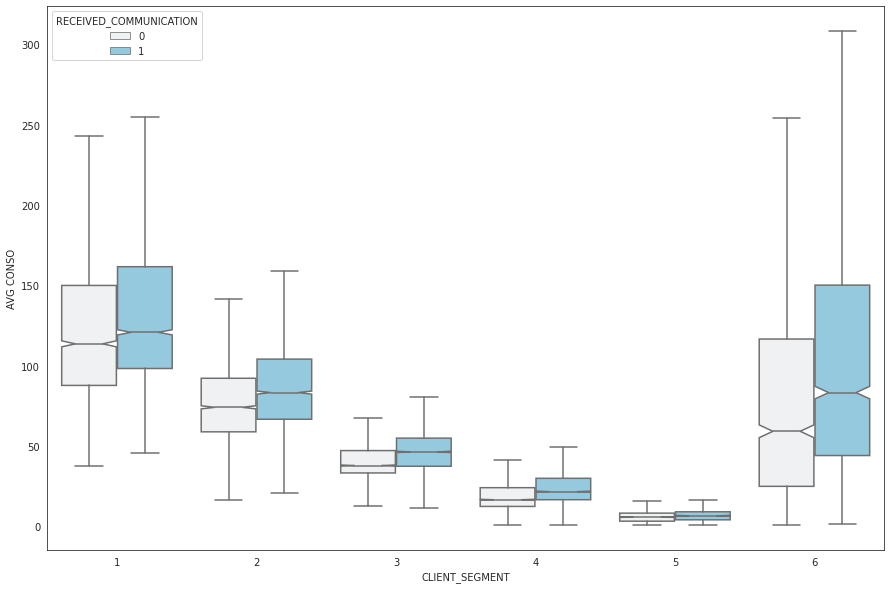

In [183]:
# boxplots para la variable 'AVG CONSO' según el tipo de segmentación del cliente y de si recibió o no promoción

plt.figure(figsize=(15,10))
sns.boxplot(data = clients, x = 'CLIENT_SEGMENT',hue = 'RECEIVED_COMMUNICATION', y = 'AVG CONSO', notch=True,showfliers=False, color='skyblue')

Del gráfico de boxplots anterior, se puede concluir claramente el impacto positivo de la promoción en el consumo medio de los clientes. Esto es, cuando el cliente ha recibido una promoción (received_communication=1) el consumo medio mensual del cliente es mayor que cuando éste no ha recibido promoción (received_communication=0). Esto se observa se cumple para todas las segmentaciones de los clientes, donde la media en el consumo medio mensual es mayor para los clientes que recibieron promoción. Únicamente para los clientes del segmento 5 se observa una diferencia muy ajustada tanto para los clientes con promocición como para los que no la recibieron.

Si bien el impacto de la promoción en el consumo medio mensual queda demostrado, es más relativo el impacto que tiene sobre el tamaño medio de la cesta del cliente ( medido en piezas de fruta), 'AVG BASKET SIZE', tal y como se muestra en el siguiente conjunto de boxplots.


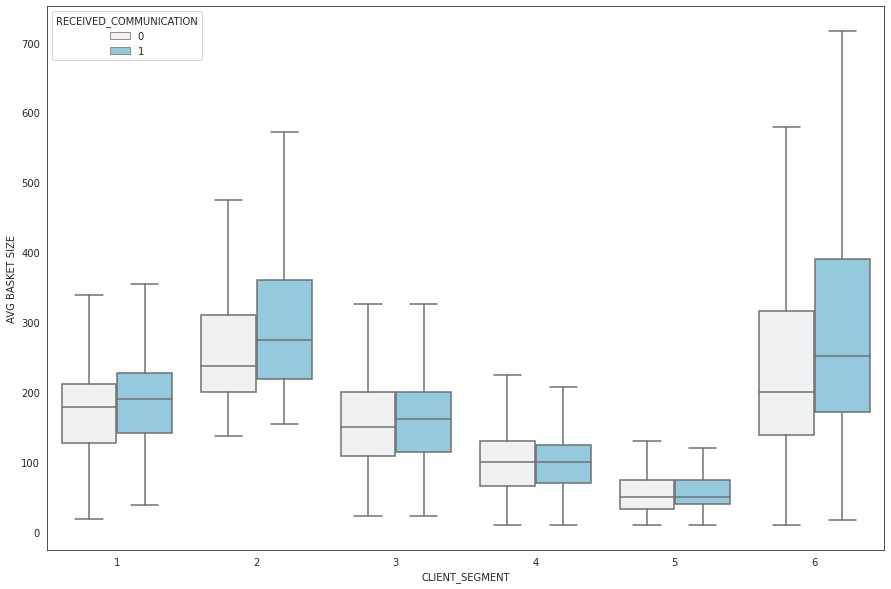

In [184]:
# boxplots para la variable 'AVG BASKET SIZE' según el tipo de segmentación del cliente y de si recibió o no promoción

plt.figure(figsize=(15,10))
sns.boxplot(data = clients, x = 'CLIENT_SEGMENT',hue = 'RECEIVED_COMMUNICATION', y = 'AVG BASKET SIZE',showfliers=False, color='skyblue')


En concreto, para los clientes de la segmentación del tipo 1, 2 y 6 se tiene que el tamaño medio de su cesta es mayor cuando reciben promoción que cuando no. Sin embargo, para los clientes con las segmentaciones 3, 4 y 5 se tiene unos valores medios de la cesta mucho más ajustados, siendo la diferencia muy poco notable para los clientes que recibieron promoción y los que no.

Así pues, se puede concluir que la promoción tiene un impacto directo sobre el tamaño consumo medio mensual del cliente, independientemente de su segmentación. Y al mismo tiempo, la promoción tiene un impacto menor a la hora de determinar el tamaño medio de la cesta del cliente, siendo aquí más relevante el tipo se segmentación al que éste pertenece.

Finalmente, es interesante notar la correlación media que presentan las variables 'AVG CONSO' y 'AVG BASKET SIZE', tal y como se muestra a continuación, situada en los 0.61.

Por lo tanto, podemos concluir que, en general, un mayor consumo medio mensual del cliente implica un mayor tamaño medio de su cesta, lo cual no deje de tener sentido.

In [185]:
# correlación entre las variables 'AVG CONSO' y 'AVG BASKET SIZE'
clients['AVG CONSO'].corr(clients['AVG BASKET SIZE'])


0.6127491019381173

#### MODELO PREDICTIVO

El objetivo es realizar un modelo predictivo que permita conocer el tipo de segmento al que pertenece cada cliente en función de las variables predictoras: 'AVG CONSO', 'AVG BASKET SIZE', 'RECEIVED_COMMUNICATION'.

Recordando el conjunto de datos que se va a usar, el dataset clients, éste constaba de un total de 35.884 registros (pedidos).

Por otro lado, nuestro objetivo es resolver un problema de clasificación multi-label, al ser el Target que queremos predecir (CLIENT_SEGMENT) una variable categórica con seis posibles valores, uno para cada segmentación del cliente.

En primer lugar, resulta interesante analizar la distribución de las clases del Target en el conjunto de datos, tal y como se hace a continuación.

segmento 1: 18.13 %
segmento 2: 18.84 %
segmento 3: 22.64 %
segmento 4: 22.09 %
segmento 5: 9.56 %
segmento 6: 8.75 %


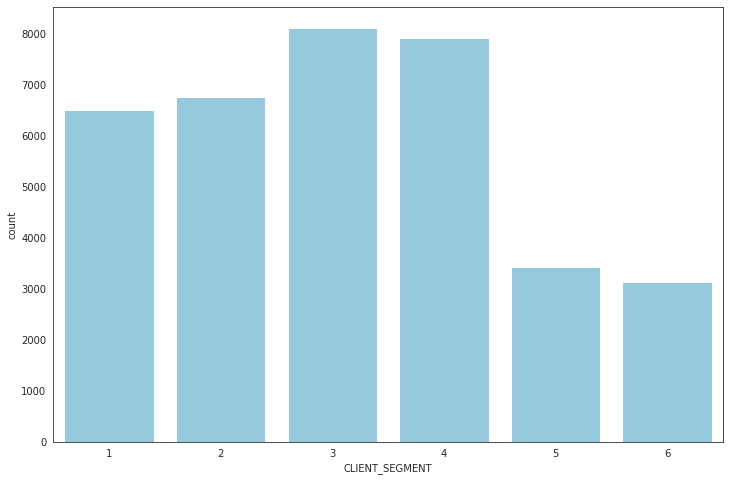

In [165]:
# Se analiza la variable Target 'clients_segment' y cómo está distribuida

sns.countplot(x='CLIENT_SEGMENT',data=clients,color='skyblue')

# para ver numéricamente la representación de cada clase:

total= len(clients) # tamaño total dataset
segment_1 = len(clients[clients['CLIENT_SEGMENT']==1]) # total clase 1
segment_2 = len(clients[clients['CLIENT_SEGMENT']==2]) # total clase 2
segment_3 = len(clients[clients['CLIENT_SEGMENT']==3]) # total clase 3
segment_4 = len(clients[clients['CLIENT_SEGMENT']==4]) # total clase 4
segment_5 = len(clients[clients['CLIENT_SEGMENT']==5]) # total clase 5
segment_6 = len(clients[clients['CLIENT_SEGMENT']==6]) # total clase 6

print('segmento 1:', round(segment_1*100/total,2),'%') # representación de la clase 1 sobre el total
print('segmento 2:', round(segment_2*100/total,2),'%') # representación de la clase 2 sobre el total
print('segmento 3:', round(segment_3*100/total,2),'%') # representación de la clase 3 sobre el total
print('segmento 4:', round(segment_4*100/total,2),'%') # representación de la clase 4 sobre el total
print('segmento 5:', round(segment_5*100/total,2),'%') # representación de la clase 5 sobre el total
print('segmento 6:', round(segment_6*100/total,2),'%') # representación de la clase 6 sobre el total



Tal y como se puede observar, las clases están balancedadas menos la clase 5 y 6 que son las que tienen menor representación, siendo la clase 6 la que tiene menor representación suponiendo solo el 8.8% del total de pedidos.

Veremos si este desbalanceo puede perjudicar nuestro modelo y cómo mejorarlo.

Empezamos a preparar el modelo predictivo.

In [186]:
# renombramos dataset de trabajo
df = clients

# Separamos el dataset entre las variables predictoras y el target (objetivo)
feature_cols = ['AVG CONSO', 'AVG BASKET SIZE', 'RECEIVED_COMMUNICATION']

X = df[feature_cols] # Features (predictoras)
y = df['CLIENT_SEGMENT'] # Target variable


# separación del dataset en train/test para el entrenamiento y el testeo
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=31415) # le definimos una seed para que los resultados sean reproducibles




De cara a la elección del algoritmo, empezamos eligiendo algo básico como un Decision Tree (C4.5/CART) o un random forest que esencialmente construye distintos árboles de decisión. Probamos ambos algoritmos y comparamos su rendimiento en base a la métrica f1-macro.

In [203]:
# Implementación de ambos modelos

classifiers = {    
    "Random Forest": RandomForestClassifier(),
    "DecisionTreeClassifier CART": DecisionTreeClassifier(max_depth=7)
}


# Evaluamos su desempeño en base a métrica f1_score y empleando la técnica 'cross_validation' como conjunto validación del resultado de la métrica

for key, classifier in classifiers.items():
  classifier.fit(X_train, y_train)
  training_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1_macro') # utilizamos un k-fold con k=5 para ahorrar en coste computacional
  print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) , "f1 (macro) scoring")

Classifiers:  RandomForestClassifier Has a training score of 0.69 f1 (macro) scoring
Classifiers:  DecisionTreeClassifier Has a training score of 0.7 f1 (macro) scoring


Podemos ver que ambos modelos proporcionan un desempeño muy similar, siendo ligeramente superior el del DecisionTree por el cual decidimos seguir trabajando con él.

A continuación, volvemos a lanzar el modelo DecisionTree y lo evaluamos sobre el conjunto test para ver su desempeño.

In [204]:
# Definimos algoritmo clasificación, utilizamos una profundidad de arbol de 7 (es la que mejor ha resultado funcionar)
clf = DecisionTreeClassifier(max_depth=7)

# Entrenamos algoritmo
clf = clf.fit(X_train,y_train)

# Predecimos labels set testeo
y_pred = clf.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      0.91      0.89      1327
           2       0.82      0.90      0.86      1364
           3       0.73      0.80      0.76      1584
           4       0.74      0.78      0.76      1598
           5       0.78      0.76      0.77       678
           6       0.24      0.07      0.11       626

    accuracy                           0.77      7177
   macro avg       0.69      0.70      0.69      7177
weighted avg       0.73      0.77      0.75      7177



Observamos que la precisión está por encima del 70% en todas las clases menos para el segmento de tipo 6 que es considerablemente menor (24%). Lo mismo ocurre con el f1 score, por encima de 0.7 para todas las clases menos para la clase 6. Lo cual, acaba proporcinando un f1-scoring medio de 0.69.

Tratamos de mejorar este modelo básico introduciendo algo más de robustez, controlando el posible overfiting y reduciendo la varianza. Esto se puede conseguir construyendo un modelo Bagging basado en nuestro weak-learner Random Forest, tal y como hacemos a continuación.

In [205]:
# defino modelo de bagging (basado en nuestro estimador incial básico 'clf')
clf_bagg = BaggingClassifier(base_estimator=clf)

#entrenamos modelo bagg
clf_bagg = clf_bagg.fit(X_train,y_train)

#predecimos niveles set testeo
y_pred_bagg = clf_bagg.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred_bagg))

              precision    recall  f1-score   support

           1       0.88      0.91      0.90      1327
           2       0.82      0.89      0.85      1364
           3       0.72      0.80      0.76      1584
           4       0.73      0.79      0.76      1598
           5       0.78      0.76      0.77       678
           6       0.29      0.09      0.13       626

    accuracy                           0.77      7177
   macro avg       0.70      0.71      0.70      7177
weighted avg       0.74      0.77      0.75      7177



Observamos de aquí que, gracias al modelo Bagging, la precisión y el f1-macro en la clase 6 se ha visto mejorada ligeramente, lo que acaba proporcionado un f1-macro medio de 0.70, es decir, se obtiene una muy pequeña mejora en la métrica f1.

Tratamos de mejorar estos resultados intentando solucionar el problema de desbalanceo de la clase 6 que es la que está perjudicando de manera más directa el resultado de la métrica f1-macro.

TRATAMIENTO PARA 'IMBALANCED DATA' de la clase 6

Una de las técnicas más ampliamente conocidas y aplicadas consiste en la aplicación de 'under sampling' y 'over sampling'.
La técnica de 'under sampling' consiste en la elección aleatoria de elementos de la clase mayoritaria y la posterior eliminación de estos del conjunto de entrenamiento. Mientras que con 'over sampling' se añaden copias al conjunto de entrenamiento de elementos pertenecientes a la clase minoritaría.
Otras técnicas más elaboradas consisten en la aplicación de la combinación de under/over samplings a la vez para reducir la importancia de la clase mayoritaria al tiempo que se incrementa la existencia de elementos de la clase minoritaria.

El enfoque escogido en el presente trabajo se centra en la técnica over sampling específicamente conocida como SMOTE (Synthetic Minority Oversampling Technique), así, podremos conseguir una mayor representatividad de la clase 6 (minoritaria) en el conjunto de datos y tratar así de mejorar nuestro modelo.

En concreto, aunque sin entrar en detalles técnicos, el algoritmo SMOTE se basa en la aplicación del algoritmo de K-nearest neighbour (KNN) para crear 'datos sintéticos'. En primer lugar, SMOTE escoge elementos aleatorios de la clase minoritaria y a continuación establece los k-vecinos más cercanos a los datos. Entonces define un vector entre uno de esos vecinos y el punto de datos actual y multiplica dicho vector por un número aleatorio entre 0 y 1. De esta forma, acaba generando datos sintéticos entre los datos aleatorios (reales) y el k-vecino más cercano seleccionado aleatoriamente. Finalmente, el conjunto de puntos sintéticos generados se acaba incorporando al conjunto global de datos reales.

Lo que se realiza a continuación es la implementación del algoritmo SMOTE para tratar el mencionado problema de desbalanceo de clases.

IMPLEMENTACIÓN DEL ALGORITMO SMOTE

A través de la librería imb.learn podemos hacer uso del ya implementado algoritmo SMOTE.

In [195]:
# miramos el número de pedidos que tenemos de cada clase antes de aplicar over_sampling con SMOTE
print("Antes de oversampling, instancias de la clase '1': {}".format(sum(y_train == 1)))
print("Antes de oversampling, instancias de la clase '2': {}".format(sum(y_train == 2)))
print("Antes de oversampling, instancias de la clase '3': {}".format(sum(y_train == 3)))
print("Antes de oversampling, instancias de la clase '4': {}".format(sum(y_train == 4)))
print("Antes de oversampling, instancias de la clase '5': {}".format(sum(y_train == 5)))
print("Antes de oversampling, instancias de la clase '6': {}".format(sum(y_train == 6)))
 
# aplicamos el algoritmo SMOTE sobre la clase minoritaria (clase 6)

# definimos objeto, algoritmo SMOTE
sm = SMOTE(random_state = 31415, sampling_strategy='minority') # aplicamos algoritmo SMOTE sobre la clase minoritaria ('minority)

# lo aplicamos a nuestro conjunto de datos
X_train_sm, y_train_sm= sm.fit_resample(X_train,y_train) # aplicamos resample sobre nuestro conjunto de datos

print('')

# miramos el número de pedidos que tenemos de cada clase después de aplicar over_sampling con SMOTE
print("Después de OverSampling, instancias de la clase '1': {}".format(sum(y_train_sm == 1))) 
print("Después de OverSampling, instancias de la clase '2': {}".format(sum(y_train_sm == 2)))  
print("Después de OverSampling, instancias de la clase '3': {}".format(sum(y_train_sm == 3)))
print("Después de OverSampling, instancias de la clase '4': {}".format(sum(y_train_sm == 4))) 
print("Después de OverSampling, instancias de la clase '5': {}".format(sum(y_train_sm == 5)))
print("Después de OverSampling, instancias de la clase '6': {}".format(sum(y_train_sm == 6)))



Antes de oversampling, instancias de la clase '1': 5178
Antes de oversampling, instancias de la clase '2': 5396
Antes de oversampling, instancias de la clase '3': 6539
Antes de oversampling, instancias de la clase '4': 6329
Antes de oversampling, instancias de la clase '5': 2751
Antes de oversampling, instancias de la clase '6': 2514

Después de OverSampling, instancias de la clase '1': 5178
Después de OverSampling, instancias de la clase '2': 5396
Después de OverSampling, instancias de la clase '3': 6539
Después de OverSampling, instancias de la clase '4': 6329
Después de OverSampling, instancias de la clase '5': 2751
Después de OverSampling, instancias de la clase '6': 6539


Observamos que, tras haber realizado over sampling sobre la clase 6, el resto de clases se mantiene intacto, pero ahora tenemos tantos elementos de la clase 6 como elementos tiene la clase mayoritaria (clase 4), esto es, 6539 elementos. Lo cual supone haber aumentado la presencia de la clase 6 minoritaria en un 160 %.

Evidentemente esta ha sido la estrategia escogida en esta resolución, se puede determinar que el ratio de crecimiento de la clase minoritaria sea menor.

Lanzamos nuevamente el modelo básico de árbol de decisión sobre el conjunto de datos con el over_sampling realizado y vemos si se obtiene algún tipo de mejora.

In [213]:
# definimos nuevamente el modelo, mantememos misma profundidad de árbol
model = DecisionTreeClassifier(max_depth=7)

#entrenamos modelo, ahora sobre el conjunto de datos over_sampled
model = model.fit(X_train_sm,y_train_sm)

#predecimos niveles set testeo
y_pred_model= model.predict(X_test)

# Imprimimos un reporting de los resultados de la evaluación del algoritmo
print(metrics.classification_report(y_test, y_pred_model))

              precision    recall  f1-score   support

           1       0.89      0.91      0.90      1327
           2       0.85      0.80      0.82      1364
           3       0.75      0.80      0.77      1584
           4       0.74      0.79      0.76      1598
           5       0.77      0.78      0.77       678
           6       0.27      0.20      0.23       626

    accuracy                           0.76      7177
   macro avg       0.71      0.71      0.71      7177
weighted avg       0.75      0.76      0.76      7177



In [214]:
# evaluación de la métrica f1-macro
metrics.f1_score(y_test,y_pred_model, average='macro')

0.7100915601856311

Se observa, gracias a la aplicación de la técnica over_sampling, una ligera mejora en el f1 de la clase 6 lo que acaba proporcionando un f1-macro medio situado en los 0.71.

Por lo tanto, podemos decir que la aplicación de la técnica over sampling mediante el algoritmo SMOTE ha proporcionado una ligera mejora en los resultados de la métrica f1-macro.

Es interesante notar las futuras líneas de mejora más inmediatas para estos modelos desarrollados, a destacar principalemente:

- Tuneo de hiperparámetros: probar distintas combinaciones de parámetros (no sólo max depth) y encontrar cuál es la mejor combinación de éstos que produce los mejores resultados, realizando un barrido por todo el espacio de búsqueda de hiper-parámetros (empleando funcionalidades como por ejemplo GridSearchCV)

- Probar técnicas de under sampling en lugar de over sampling, donde lo que se reduce en este caso es la presencia de clases mayoritarias.

- Probar combinaciones de over sampling y under sampling

- Desarrollar meta-algoritmos más robustos basados en weaks learners


#### PREDICCIONES DEL CONJUNTO TESTING PROPORCIONADO

In [215]:
# miramos la estructura de los datos que queremos predecir
test.head()

,CLIENT ID,AVG CONSO,AVG BASKET SIZE,RECEIVED_COMMUNICATION
0,48352078,8.33,100.00,0
1,18072186,93.42,186.83,1
2,48352246,45.83,137.50,0
3,18070621,16.67,200.00,1
4,48352262,13.33,160.00,0


In [ ]:
test.isnull().values.any() # comprobación que no hay NaN

False

El resto de procedimiento es esencialmente el mismo para la preparación de los datos. Una vez preparados, realizamos las predicciones sobre el Target.

In [216]:
# preparación de los datos

df = test

feature_cols = ['AVG CONSO', 'AVG BASKET SIZE', 'RECEIVED_COMMUNICATION'] # conjunto de variables predictoras

X = df[feature_cols] # Features

# el modelo ya entrenado anteriormente (clf_bagg) lo utilizamos para predecir este nuevo conjunto de datos
test_X_pred = model.predict(X)

In [217]:
# creamos dataframe de las predicciones (bajo el formato solicitado)

X_pred = pd.DataFrame({'CLIENT ID':df['CLIENT ID'],
        "predicciones": test_X_pred 
    })

X_pred.to_csv('Predicciones.csv', index= False)


In [220]:
# descargamos .csv con las predicciones
from google.colab import files
files.download('Predicciones.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [222]:
/

()